# Machine Learning in Python - Project 1

Due Friday, March 6th by 5 pm.

## 1. Setup

### 1.1 Libraries

In [1]:
# Add any additional libraries or submodules below


# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80
sns.set_palette('husl')

# sklearn modules
import sklearn

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.pipeline import make_pipeline

from sklearn import linear_model

### 1.2 Data

In [2]:
sales = pd.read_csv("sales.csv")
sales_test = pd.read_csv("sales_test.csv")

sales = pd.concat([sales, sales_test], ignore_index = True,sort = False)

## 2. Exploratory Data Analysis and Preprocessing

We will start by looking at the correlation matrix.

<AxesSubplot:>

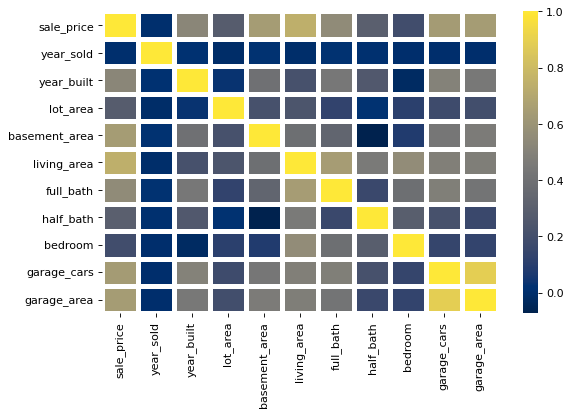

In [3]:
sns.heatmap(sales.corr(), linecolor = 'white', cmap = 'cividis', linewidths = 3)

The features in correlation matrix appear to be as such. 

In [4]:
corr = sales.corr()
corr.sort_values(["sale_price"], ascending = False, inplace = True)
print(corr.sale_price)

sale_price       1.000000
living_area      0.741814
basement_area    0.642316
garage_area      0.640058
garage_cars      0.638957
full_bath        0.547388
year_built       0.525693
half_bath        0.296369
lot_area         0.280791
bedroom          0.190535
year_sold        0.003999
Name: sale_price, dtype: float64


Based on the situation above we should consider adding the polynomial features some of the most relevant features as well as cross-product to normalise the correlated ones. However, that would be subject to further discussion in the following cells.

If we look into the plots of ``sales_price`` against each of the parameters we may notice the outliers in ``lot_area`` and ``sales_price`` itself.

<AxesSubplot:xlabel='lot_area', ylabel='sale_price'>

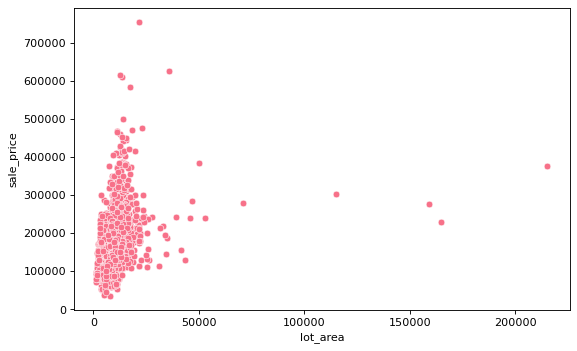

In [5]:
sns.scatterplot(y = sales['sale_price'], x = sales['lot_area'], markers=".")

These are few examples of quite a big piece of land sold for the relatively small price. As we can see from the linear pattern on this picture, we can treat outliers to be values with ``lot_area`` $>60.000$ square feet.

In [6]:
sales = sales[sales.lot_area < 60000]
print("Now the data has " + str(sales.shape[0])+ " entries")

Now the data has 1929 entries


<AxesSubplot:xlabel='sale_price'>

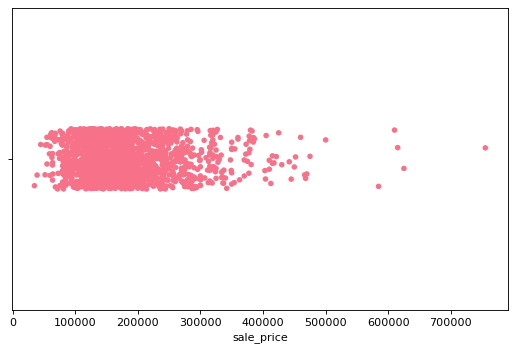

In [7]:
sns.stripplot(x = sales['sale_price'])

In [8]:
sales = sales[sales.sale_price < 550000]
print("Now the data has " + str(sales.shape[0])+ " entries")

Now the data has 1924 entries


Now we want to look into the structure of our data.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sale_price', ylabel='Density'>

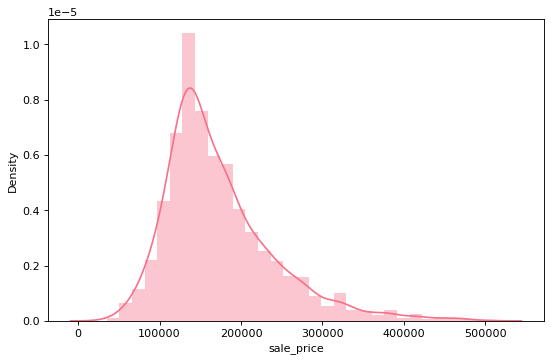

In [9]:
sns.distplot(sales["sale_price"], kde = True, bins = 30)

As we can see, the data is skewed and cannot be fairly treated as normal. That will result into great predictivity for average-priced house, but grand error for expansive and luxury mansions. That happens since the conditions of regression model are violated, thus we will try to analyse skewness, using ``skew()`` function of Pandas and modify our data (features and ``sale_price`` lately on).

In [10]:
num_feat = sales.select_dtypes(exclude = ['object']).columns
num_feat = num_feat.drop(['sale_price','half_bath'])
skewness = sales[num_feat].skew()
skewness = skewness[abs(skewness) > 0.5]

print(skewness)

year_built    -0.545686
lot_area       2.682817
living_area    0.846666
dtype: float64


We choose to use log-transform of the data, as it helps to deal with skewness. However we need to ensure that our features do not include $0$ values, so applying $\log$ is valid. Since all the skewed features have quite a big order ($ > 10^3)$, we will replace $0$ by $1$ and that should not drastically affect the quality of our analysis.

To avoid a mistake we switch off the chained assignment.

In [11]:
pd.options.mode.chained_assignment = None

sk_feat = skewness.index

sales['year_built'] = sales.year_built.replace({0 : 1})
sales['lot_area'] = sales.lot_area.replace({0 : 1})
sales['basement_area'] = sales.basement_area.replace({0 : 1})
sales['living_area'] = sales.living_area.replace({0 : 1})

sales_test['year_built'] = sales_test.year_built.replace({0 : 1})
sales_test['lot_area'] = sales_test.lot_area.replace({0 : 1})
sales_test['basement_area'] = sales_test.basement_area.replace({0 : 1})
sales_test['living_area'] = sales_test.living_area.replace({0 : 1})


sales[sk_feat] = np.log(sales[sk_feat])
sales_test[sk_feat] = np.log(sales_test[sk_feat])

Get-dummies

In [12]:
sales = pd.get_dummies(sales)
sales_test = pd.get_dummies(sales_test)

We finally split our data into prediction matrix and observations and scale the former.

In [13]:
y_train = np.log(sales.sale_price)
X_train = sales.drop(['sale_price'], axis = 1)
y_test = np.log(sales_test.sale_price)
X_test = sales_test.drop(['sale_price'], axis = 1)

# apply scaling, based on the whole amount of data we have

S = StandardScaler().fit(pd.concat([X_train, X_test], ignore_index = True,sort = False))

X_train_scaled = S.transform(X_train)
X_test_scaled = S.transform(X_test)

## 3. Model Fitting and Tuning

I proceed by choosing standard linear model, as decision trees and Ridge/Lasso regularisation are not giving me a desired precision on a validation set.
We will not consider ``PolynomialFeatures`` by numerous reasons. Firtly, the $\log$-transform, imposed on the skewed features (the most important features, as given by correlation matrix) is already capturing all potential polinomial relations by adjusting the regression coefficient, however calculating polinomial features on $\log$-scaled predictors does not make any sense. Secondly, the data-relation does not resemble non-linear polynomial relation for non-skewed data. Finally, the higher degree will lead to increasing computational complexity as well as potential overfitting.

That is not theoretical conclusions, but empirical as well, as I made my hands very dirty seeking for the best model :)

RMSE on log-sales in train sample: 0.10546470935966525
RMSE on log-sales in test sample: 0.10746583505207918
RMSE on sales in train sample: 19090.931070216437
RMSE on sales in test sample: 19670.145057947524
R^2 score on sales in train sample: 0.9192801143508245


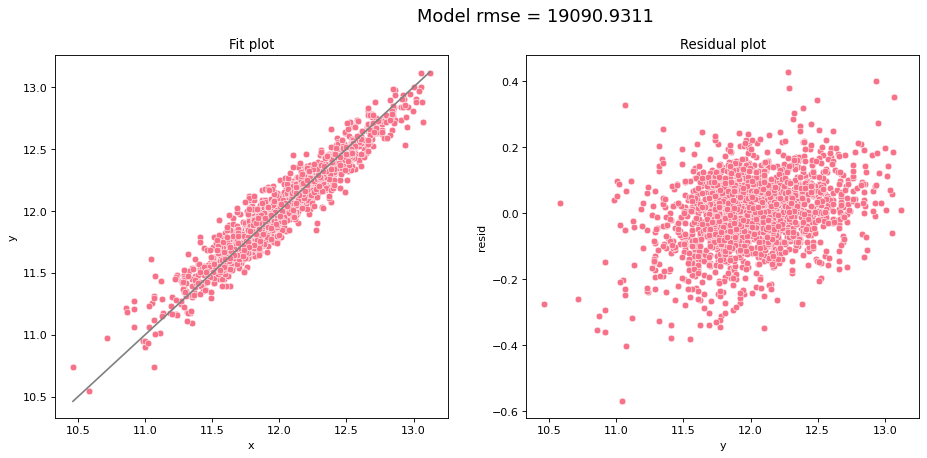

In [14]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

log_err1 = np.sqrt(mean_squared_error(lr.predict(X_train_scaled), y_train))
log_err2 = np.sqrt(mean_squared_error(lr.predict(X_test_scaled), y_test))
err1 = np.sqrt(mean_squared_error(np.e ** lr.predict(X_train_scaled),np.e ** y_train))
err2 = np.sqrt(mean_squared_error(np.e ** lr.predict(X_test_scaled), np.e ** y_test))

print('RMSE on log-sales in train sample: '+ str(log_err1))
print('RMSE on log-sales in test sample: '+ str(log_err2))
print('RMSE on sales in train sample: '+ str(err1))
print('RMSE on sales in test sample: '+ str(err2))

print('R^2 score on sales in train sample: ' + str(r2_score(np.e ** y_train,np.e ** lr.predict(X_train_scaled))))

def model_fit(m, X, y, plot = True):

    y_hat = m.predict(X)
    rmse = np.sqrt(mean_squared_error(np.e ** y, np.e ** y_hat))
    
    res = pd.DataFrame(
    data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='x', y='y', color="grey", data =  pd.DataFrame(data={'x': [min(y),max(y)], 'y': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    return rmse

model_fit(lr,X_train_scaled,y_train)

final_model = lr

A couple of words on the models that were not selected. Tikhonov regularisation was performing almost in the same way as a current model. Principle of the Okkam's rasor clearly advise us to choose the simpler one, especially when it is relatively easy to interpret for the general audience. Lasso regression was performing worse as well as eliminating features that were important in the analysis of the sale price. Finally, regression trees are not well suited for this model, since our data is not 'levelled', but is rather smooth and sparse.
All of them fail with their predictive accuracy and lack interpretation.

Please see appendix code to get the idea on errors.

Now we use that we are given an initial split of the dataset and merge training and testing parts, as the validation is to be done on brand new `sales_holdout.csv` part and we want to get as **bigger predictability** as we can achieve.

I do not want to overrun the complexity of that 'magnus opus', thus will simply switch to the whole data in Section 1.2.

## 4. Discussion


As we know from the real estate market, pricing the house is quite a difficult task. The whole variability of factors are taken into consideration, as the physical features, i.e. area of the indoor/outdoor, number of chambers, bathrooms, garage, condition, etc. and urban parameters such as residential density and neighbourhood.
That factors all contribute to determination of the fair market price.

Our model acts as follows. It suggests that the best approximation for the sale_price is just the sum of the relative features with some weights. **Every** factor contributes its bit (maybe tiny, but still) towards establishing the price and that ensures that any particular variation matters. If you live in the exactly same house as your neightbour, but you have an air conditioning, but he does not, be sure, that your house costs more, because this difference **matters**. And that is easy to calculate!

Our model incorporates error an around $\$20.000$, meaning that the actual price of your flat may be beyond our prediction by this sum. But that is where the desicion of the selling party comes into the play, according to the market situation and personal preferences.

However, having $R^2$-score to be $0.92$ is quite a decent indication that approximation achieved by our model is very precise. In other words, our model explains 92% of the given data. What is justified by looking at our initial plots, is that real estate business has quite a decent amount of unexplainable variation. Real estate agencies are evaluating according to the market data, however the final word for price comes from the owner/landlord, which includes human factor. At the same time real estate market may not be rather stable (our data includes listings for 2006-2010, which captures the period of financial crisis at least, not mentioning inflation and other volatility within market economy), and that may lead to a decline in demand/supply and thus affects the variation of the house price.

## 5. Model Validation

See Section 4 for detailed analysis.

In [15]:
sales_holdout = pd.read_csv("sales_holdout.csv")

# Adjust this code as necessary to preprocess the holdout data
X_holdout = sales_holdout.drop('sale_price', axis=1)
y_holdout = sales_holdout.sale_price
X_holdout['year_built'] = X_holdout.year_built.replace({0 : 1})
X_holdout['lot_area'] = X_holdout.lot_area.replace({0 : 1})
X_holdout['basement_area'] = X_holdout.basement_area.replace({0 : 1})
X_holdout['living_area'] = X_holdout.living_area.replace({0 : 1})

X_holdout[sk_feat] = np.log(X_holdout[sk_feat])
X_holdout = pd.get_dummies(X_holdout)

X_holdout = S.transform(X_holdout)

The RMSE on the testing set:

In [16]:
np.sqrt(sklearn.metrics.mean_squared_error(y_holdout, np.e ** lr.predict(X_holdout)))

19670.145057947542